In [1]:
import pickle
import pandas as pd
import spacy
import numpy as np
import collections
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.neural_network
#nlp = spacy.load('en')

In [2]:
with open('data/parsed_text.pic', 'rb') as f:
    doc_data = pickle.load(f)
print(doc_data.keys())
doc_data['good'][0]

dict_keys(['good', 'bad', 'slowed', 'rec'])


The type of research I was working on and the flexibility I had on selecting which problems to focus on.

In [3]:
tokenized = dict()
for q, docs in doc_data.items():
    tokenized[q] = [[tok.lower_ for tok in doc if not tok.is_stop and not tok.is_punct and not tok.like_num and not tok.is_space] for doc in docs]
tokenized['good'][0][:10]

['type',
 'research',
 'working',
 'flexibility',
 'selecting',
 'problems',
 'focus']

## TF-IDF and Comparisons

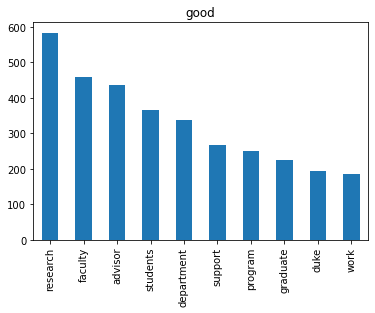

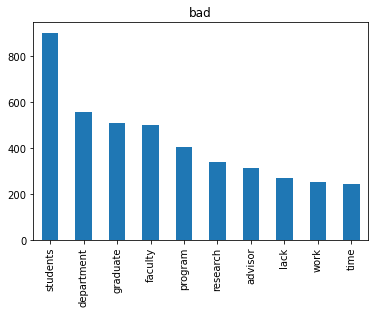

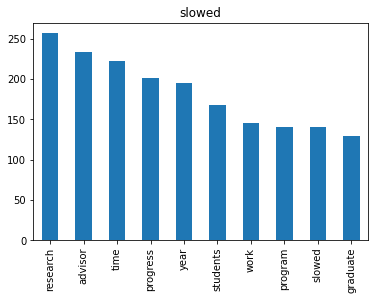

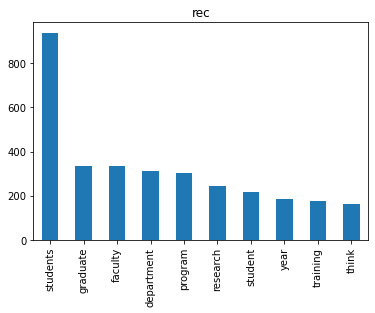

In [4]:
import matplotlib.pyplot as plt

for q, resps in tokenized.items():
    cts = collections.Counter([t for resp in resps for t in resp])
    s = pd.Series(cts).sort_values(ascending=False).head(10)
    s.plot.bar(title=q)
    plt.show()

In [5]:
scounts = dict()
for q, resps in tokenized.items():
    cts = collections.Counter([t for resp in resps for t in resp])
    sct = pd.Series(cts).sort_values(ascending=False)
    scounts[q] = sct/sct.sum()
df = pd.DataFrame(scounts)
#df = df.fillna(0)
df = df.dropna()
df.head(3)

,good,bad,slowed,rec
$,0.000106,0.000698,0.000352,0.000461
+,0.000106,0.000243,0.000422,0.000084
1st,0.000053,0.000061,0.000141,0.000336


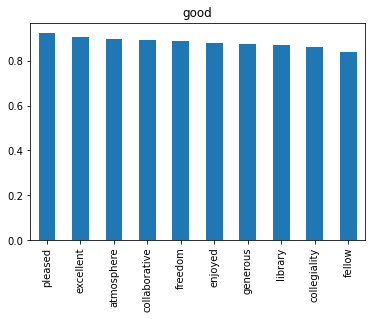

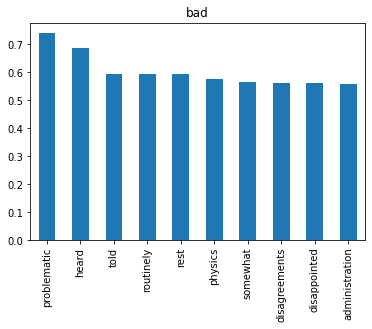

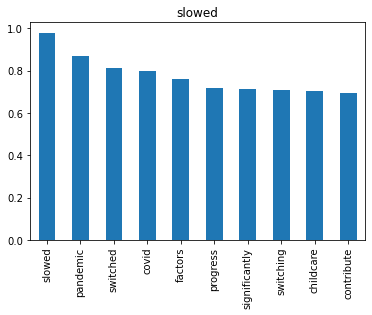

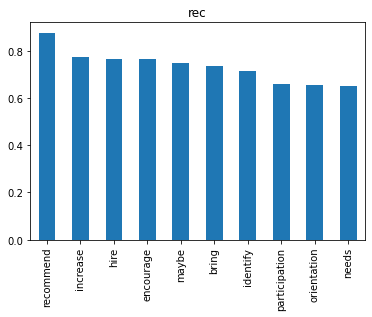

In [6]:
sdf = df.copy()
rowsums = sdf.sum(axis=1)
colnames = list(df.columns)
for col in colnames:
    sdf[col] = sdf[col]/rowsums
    #sdf[col].sort_values(ascending=False)
    sdf[col].sort_values(ascending=False).head(10).plot.bar(title=col)
    plt.show()
#sdf['good'].sort_values(ascending=False)#.filter(lambda x: x < 1)

## BoW/DTM Representations

In [7]:
all_docs = [(q,toks) for q,resps in tokenized.items() for toks in resps]
questions = [q for q,d in all_docs]
responses = [d for q,d in all_docs]
responses[0]

['type',
 'research',
 'working',
 'flexibility',
 'selecting',
 'problems',
 'focus']

In [8]:
min_tf = 5
vectorizer = CountVectorizer(tokenizer = lambda x: x, preprocessor=lambda x:x, min_df=min_tf)
corpus = vectorizer.fit_transform(responses)
vocab = vectorizer.get_feature_names()
DTM = corpus.toarray()
len(vocab), type(corpus), corpus.shape, DTM.shape

(2288, scipy.sparse.csr.csr_matrix, (12968, 2288), (12968, 2288))

Use PCA to reduce dimensionality.

In [9]:
clf = TruncatedSVD(500)
Xpca = clf.fit_transform(DTM)
Xpca

array([[ 0.26213521, -0.60128255, -0.1734355 , ...,  0.05100844,
         0.06799603, -0.00283399],
       [ 0.59361425, -1.13825636, -0.34160094, ..., -0.0401644 ,
         0.00645764, -0.0569639 ],
       [ 0.37608537, -0.10543464,  0.81168077, ...,  0.00913884,
        -0.04053687, -0.00479307],
       ...,
       [ 0.83244843, -0.44550826,  0.62246201, ...,  0.0084908 ,
         0.14169425, -0.10469736],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]])

# Demographic Regression Models

In [10]:
min_tf = 5
vectorizer = CountVectorizer(tokenizer = lambda x: x, preprocessor=lambda x:x, min_df=min_tf)
corpus_good = vectorizer.fit_transform(tokenized['good'])
vocab_good = vectorizer.get_feature_names()
DTM_good = corpus_good.toarray()
voc2id = {w:i for i,w in enumerate(vocab_good)}
len(vocab_good), type(corpus_good), corpus_good.shape, DTM_good.shape

(616, scipy.sparse.csr.csr_matrix, (3242, 616), (3242, 616))

In [11]:
df = pd.read_csv('data/exit_survey.csv', skiprows=[1,2], usecols=['Q65', 'Q69'])
print(df.shape)
df['mention_advisor'] = DTM_good[:,voc2id['advisor']]
df['mention_lab'] = DTM_good[:,voc2id['lab']]
df['num_words'] = DTM_good.sum(axis=1)
df.head(2)

(3242, 2)


,Q65,Q69,mention_advisor,mention_lab,num_words
0,Male,White (non-Hispanic),0,0,5
1,Female,White (non-Hispanic),1,0,8


In [12]:
import statsmodels.formula.api as smf
mod = smf.ols('mention_advisor ~ Q65 + num_words', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        mention_advisor   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     154.4
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           1.89e-64
Time:                        16:22:22   Log-Likelihood:                -1210.9
No. Observations:                2904   AIC:                             2428.
Df Residuals:                    2901   BIC:                             2446.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0855      0.012      7.428      

In [13]:
mod = smf.ols('mention_lab ~ Q65 + num_words', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mention_lab   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     60.84
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           1.31e-26
Time:                        16:22:22   Log-Likelihood:                 573.57
No. Observations:                2904   AIC:                            -1141.
Df Residuals:                    2901   BIC:                            -1123.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0161      0.006      2.585      

## Classification

In [14]:
nn = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[100])
nn.fit(Xpca, questions)

MLPClassifier(hidden_layer_sizes=[100])

In [15]:
predicted_questions = list(nn.predict(Xpca))
np.mean([q==pq for q,pq in zip(questions, predicted_questions)])

0.5967766810610734

## Doc Vectors
Each row is a document vector.

In [16]:
clf = TruncatedSVD(100)
docvecs = clf.fit_transform(DTM)
docvecs.shape

(12968, 100)

In [17]:
target = docvecs[0]
#target.dot()
docvecs.dot(target)

array([2.14128481, 1.10115577, 0.130894  , ..., 0.08235794, 0.        ,
       0.        ])

### Topic Modeling

In [18]:
# non-negative matrix factorization (similar to pca but for only positive-entry matrices)
nmf_model = NMF(n_components=3).fit(DTM)
doc_topics = nmf_model.transform(DTM)
topic_words = nmf_model.components_
topic_words.shape, doc_topics.shape

((3, 2288), (12968, 3))

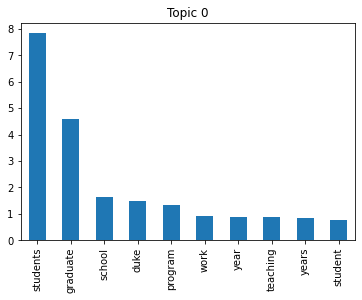

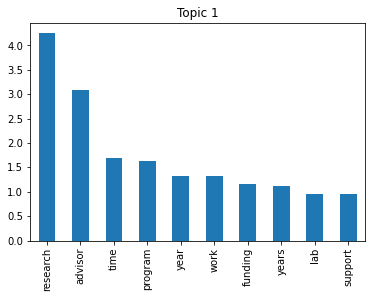

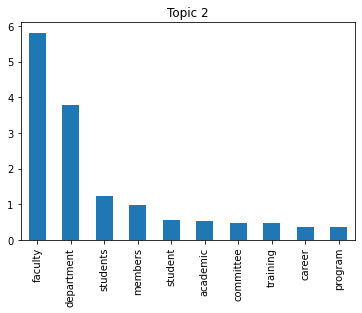

In [19]:
def show_topics(vocab, topic_words, topic):
    s = pd.Series({v:p for v,p in zip(vocab, topic_words[topic])})
    s.sort_values(ascending=False).head(10).plot.bar(title=f'Topic {topic}')
    
for i in range(topic_words.shape[0]):
    show_topics(vocab, topic_words, i)
    plt.show()